In [1]:
import warnings
import tensorflow as tf
warnings.filterwarnings('ignore')
tf.get_logger().setLevel('ERROR')
import numpy as np
import pandas as pd
import yfinance as yf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import pmdarima as pm
from statsmodels.tsa.api import AutoReg
import pickle
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt, ExponentialSmoothing
from sklearn.metrics import mean_absolute_error
from prophet import Prophet
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import json
import os
from os.path import exists

import sys
sys.path.insert(0, "../Src/")
import loadData

%autosave 5

Autosaving every 5 seconds


Autosaving every 5 seconds


In [2]:
def stabalize(data):
    p = 100
    while p > 0.05:
        adfTest = adfuller(data)
        p = adfTest[1]
        print(f'p: {adfTest[1]}')
        if p > 0.05:
            data = data.diff().dropna()
    return data

In [3]:
def trainArima(data):
    print('Training ARIMA')
    data = stabalize(data)
    possibleP = np.arange(5)
    possibleD = np.arange(5)
    possibleQ = np.arange(5)

    train, dev = trainDevSplit(data)

    bestArima = None
    bestMAE = np.inf
    bestP, bestQ = 0, 0

    for _ in range(20):
        p = np.random.choice(possibleP)
        d = np.random.choice(possibleD)
        q = np.random.choice(possibleQ)
        arima = ARIMA(train, order=(p, d, q))
        arimaFit = arima.fit()
        forecast = arimaFit.forecast(len(dev))
        mae = mean_absolute_error(dev, forecast)
        if mae < bestMAE:
            bestMAE = mae
            bestP, bestD, bestQ = p, d, q
    arima = ARIMA(data, order=(bestP, bestD, bestQ))
    arimaFit = arima.fit()
    print(arimaFit.summary())
    residuals = arimaFit.resid[1:]

    fig,ax = plt.subplots(1,2)
    residuals.plot(title = 'Residuals', ax = ax[0])
    residuals.plot(title = 'Density', kind = 'kde', ax = ax[1])

    saveModel(arimaFit, 'arima')
    return arimaFit

In [4]:
def saveModel(model,name):
    filename = f'../Models/{name}.pkl'
    if name in ['autoRegression','sarima','ExponentialSmoothing', 'prophet']:
        with open(filename, 'wb') as pkl:
            pickle.dump(model, pkl)
    else:
        model.save(filename)

In [5]:
def trainSarima(train):
    print('Training Sarima')
    sarima = pm.auto_arima(train,stepwise=True,seasonal=True)
    print(sarima.summary())
    saveModel(sarima,'sarima')
    return sarima

In [6]:
def trainAutoRegression(data):
    print('Training AutoRegression')
    bestLag = 0
    bestCorr = 0
    for lag in range(1,11):
        corr = data.corr(data.shift(lag))
        if corr > bestCorr:
            bestLag = lag
            bestCorr = corr
    print(f'AR order = {bestLag}')
    ar_model = AutoReg(data, lags=bestLag)
    ar_model = ar_model.fit()
    saveModel(ar_model,'autoRegression')
    return ar_model
    

In [7]:
def trainExponentialSmoothing(data):
    print('Training ExponentialSmoothing')
    arrayData = np.asarray(data)
    trainDevCutOff = int(len(arrayData) * 0.8)
    train = arrayData[:trainDevCutOff]
    dev = arrayData[trainDevCutOff:]

    possibleModels = [SimpleExpSmoothing, Holt, ExponentialSmoothing]
    possibleModelNames = ["SimpleExpSmoothing", "Holt", "ExponentialSmoothing"]
    bestMAE = np.inf

    bestModelIndex = 0
    bestSmoothingLevel = 0
    for _ in range(20):
        smoothingLevel = np.random.uniform(0.1, 0.9)
        modelIndex = np.random.choice(len(possibleModels))
        modelConstructor = possibleModels[modelIndex]
        model = modelConstructor(train)
        model_fit = model.fit(smoothing_level=smoothingLevel)
        forecast = model_fit.forecast(len(dev))
        mae = mean_absolute_error(dev, forecast)
        if mae < bestMAE:
            bestMAE = mae
            bestModelIndex = modelIndex
            bestSmoothingLevel = smoothingLevel
            
    print(f'model chosen {possibleModelNames[bestModelIndex]}')
    print(f'smoothing parameter {bestSmoothingLevel}')
    finalModelConstructor = possibleModels[bestModelIndex]
    final_model = finalModelConstructor(arrayData)
    final_model_fit = final_model.fit(smoothing_level=bestSmoothingLevel)
    
    saveModel(final_model_fit, 'ExponentialSmoothing')
    return model
    

In [8]:
def trainProphet(data):
    print('Training Prophet')
    train, dev = trainDevSplit(data)
    display(train)
    display(dev)

    bestMAE = np.inf
    bestParams = {}
    
    for _ in range(20):
        params = retrieveProphetParams()
        model = Prophet(**params)
        model.fit(train)
        
        future = model.make_future_dataframe(periods=dev.shape[0], freq='D')
        capValue = dev['y'].max() * 1.1
        future['cap'] = capValue
        future['floor'] = 0
        forecast = model.predict(future)
        forecast = forecast.iloc[-dev.shape[0]:]
        
        mae = mean_absolute_error(dev['y'], forecast['yhat'])
        
        if mae < bestMAE:
            bestMAE = mae
            bestParams = params
            

    model = Prophet(**bestParams)
    model.fit(data)
    
    saveModel(model, 'prophet')
    return model
        

In [9]:
def retrieveProphetParams():
    param_space = { 'growth' :['linear', 'logistic', 'flat'],
                   'n_changepoints': np.arange(0, 55, 5),
                   'changepoint_range': (0.5, 0.5),
                   'yearly_seasonality': [True, False],
                   'weekly_seasonality': [True, False],
                   'daily_seasonality': [True, False],
                   'seasonality_mode': ['additive', 'multiplicative'],
                   'seasonality_prior_scale': (5.0, 15.0),
                   'changepoint_prior_scale': (0.0, 0.1),
                   'interval_width': (0.2, 0.8),
                   'uncertainty_samples': [500, 1000, 1500, 2000]
                  }
    chosenParameters = dict()
    for key in param_space:
        if key in ['changepoint_range','seasonality_prior_scale','changepoint_prior_scale','interval_width']:
            bounds = param_space[key]
            chosenParameters[key] = np.random.uniform(bounds[0],bounds[1])
        else:
            chosenParameters[key] = np.random.choice(param_space[key])
    return chosenParameters
    

In [10]:
def trainLSTM(data):
    train, dev = trainDevSplit(data)
    XData, yData = loadData.processDataForLSTM(data)
    XTrain, yTrain = loadData.processDataForLSTM(train)
    XDev, yDev = loadData.processDataForLSTM(dev)
    
    bestTrainScore = np.inf
    bestDevScore = np.inf
    bestLSTMUnits1 = 0
    bestLSTMUnits2 = 0
    bestEpochs = 0
    for trial in range(20):    
        lstmUnits1 = np.random.choice(range(1,128))
        lstmUnits2 = np.random.choice(range(1,128))
        epochs = np.random.choice(range(1,100))

        model = compileLSTM(XTrain,yTrain,lstmUnits1,lstmUnits2,epochs)
        
        devScore = model.evaluate(XDev,yDev)[1]
        if devScore < bestDevScore:
            bestTrainScore = model.evaluate(XTrain,yTrain)[1]
            bestDevScore = devScore
            bestLSTMUnits1 = lstmUnits1
            bestLSTMUnits2 = lstmUnits2
            bestEpochs = epochs
    compileLSTM(XData,yData,bestLSTMUnits1,bestLSTMUnits2,bestEpochs)
    
    model_path = f'../Models/LSTM_.h5'
    model.save(model_path)
    bestModelParams = {
        'bestTrainScore': int(bestTrainScore),
        'bestDevScore': int(bestDevScore),
        'bestLSTMUnits1': int(bestLSTMUnits1),
        'bestLSTMUnits2': int(bestLSTMUnits2),
        'bestEpochs': int(bestEpochs)
    }
    with open('../Models/lstm_params.json', 'w') as f:
        json.dump(bestModelParams, f)
    
    return model
        

In [11]:
def trainDevSplit(data):
    totalRows = data.shape[0]
    trainDevCutoff = int(0.8 * totalRows)
    train = data.iloc[:trainDevCutoff]
    dev = data.iloc[trainDevCutoff:]
    return train,dev

In [12]:
def compileLSTM(X,y,lstmUnits1,lstmUnits2,epochs):
    model = Sequential()
    model.add(LSTM(units=lstmUnits1, return_sequences=True, input_shape=(X.shape[1], 1)))
    model.add(LSTM(units=lstmUnits2))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_absolute_error',metrics=['mean_absolute_error'])
    model.fit(X, y, epochs=epochs, batch_size=32,verbose=0)
    return model

In [13]:
def main():
    train, test = loadData.loadData('MSFT')
    if exists('../Models/autoRegression.pkl') == False:
        trainAutoRegression(train['y'])
    if exists('../Models/arima.pkl') == False:
        trainArima(train['y'])
    if exists('../Models/sarima.pkl') == False:
        trainSarima(train['y'])
    if exists('../Models/ExponentialSmoothing.pkl') == False:
        trainExponentialSmoothing(train['y'])
    if exists('../Models/prophet.pkl') == False:
        trainProphet(train)
    
    if exists('../Models/LSTM_.h5') == False:
        trainLSTM(train['y'])

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Training ARIMA
p: 0.8724888850412795
p: 1.2499416193356876e-18
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1046
Model:                 ARIMA(1, 0, 2)   Log Likelihood               -3125.956
Date:                Sun, 24 Nov 2024   AIC                           6261.912
Time:                        22:29:44   BIC                           6286.676
Sample:                             0   HQIC                          6271.303
                               - 1046                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2415      0.129      1.871      0.061      -0.011       0.494
ar.L1          0.3436      0.844      0.407      0.684      -1.311  

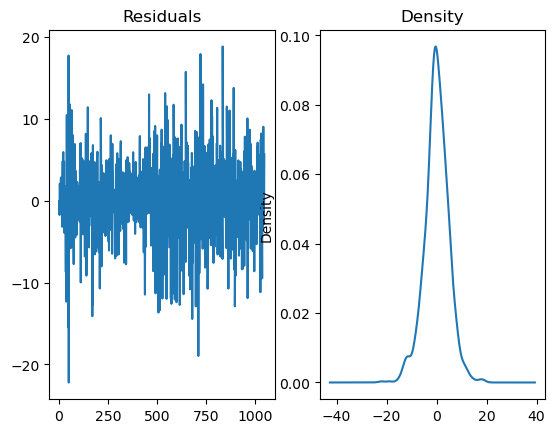

In [14]:
if __name__ == '__main__':
    main()